<h1 style="text-align: center;">Spectrum of the Hamiltonian and a bit of Julia <h1>



The Hamiltonian of interest is given by 
$$
H_{\text{full}}(t) = \omega_0 a^\dagger a + \sum_{n=3}^\infty g_n (a^\dagger + a)^n - i\Omega_d \cos(\omega_d t) (a -a^\dagger),
$$
where depending on which paper I read or who I ask one can see $g_n$ defined as $g_n/n$, a factor of $2$ in front of the $\Omega_d$ term, and even an extra driving $\propto \Omega_1 \cos(\omega_1 t) (a -a^\dagger)$. These differences are mostly trivial but know they exist. We now proceed to investigate the spectrum of $H_{\text{full}}(t)$ under several regimes: an static effecitve regime (Sec. 1 bellow) and a Floquet regime (Sec. 2).

## 1. Spectrum of the static effective Hamiltonian
We follow https://arxiv.org/pdf/2210.07255.pdf, in particular we start with hamiltonian (¿añadir derivation?)
$$
H_{qu}/K = a^\dagger a (a^\dagger a-1) -\xi (a^{\dagger 2} + a^2),
$$
with $\xi=\epsilon_2 / K$. Now, we can rewrite this in a simpler form 
$$
H_{qu}/K = a^\dagger a a^\dagger a- a^\dagger a  -\xi (a^{\dagger 2} + a^2) = a^{\dagger 2} a^2  -\xi (a^{\dagger 2} + a^2).
$$
We can easily implement this Hamiltonian in Julia by defining 

In [5]:
include("../src/src.jl") # import src.jl which has creation/annahilation operators defined

function H_qu(N, ξ)
    A = a(N) # annahilation op. up to dim N
    return  (A'^2)*(A^2) -  ξ*(A'^2 + A^2) 
end

H_qu (generic function with 1 method)

where `N` is the Hilbert space dimension cut-off. In principle, if the initial state is very localised, say exponentially localised in an energy window $\Delta E$, then the corrections to expectation values and amplitudes are exponentially suppresed $\delta(N) \sim \exp(2\Delta E)$. (This could be done in a sexy one-liner via `f(x) = x^2` but let's not complicate things). 

We now study the spectra of $H_{qu}$ to reproduce Fig. 1a & 1b. We choose a high `N=100` as this is essentially, for now, computationally free. 

In [73]:
using LinearAlgebra # to diagonalise stuff
using DataFrames # this is like pandas

# Define parameter space
N = 100
ξ_array = Vector(0:0.01:12)

# Define data form
data_array = zeros( N*length(ξ_array), 3 ) # data form: E_n | xi | N

# Generate data within parameter space
counter = 1
for ξ in ξ_array
    H = Hermitian( H_qu(N, ξ) )
    lamb, _ = eigen(H)
    for i=1:N
        data_array[counter,:] .= lamb[i]-minimum(lamb), ξ, N
        counter += 1
    end
end

# put data in convinient DataFrame object
df = DataFrame(data_array, ["E_n","ξ","N"]) 

Row,E_n,ξ,N
,Float64,Float64,Float64
1,0.0,0.0,100.0
2,0.0,0.0,100.0
3,2.0,0.0,100.0
4,6.0,0.0,100.0
5,12.0,0.0,100.0
6,20.0,0.0,100.0
7,30.0,0.0,100.0
8,42.0,0.0,100.0
9,56.0,0.0,100.0


Let's now plot the "renormalised" spectrum of $H_{qu}$, that is $E-E_0$ against $\xi$:

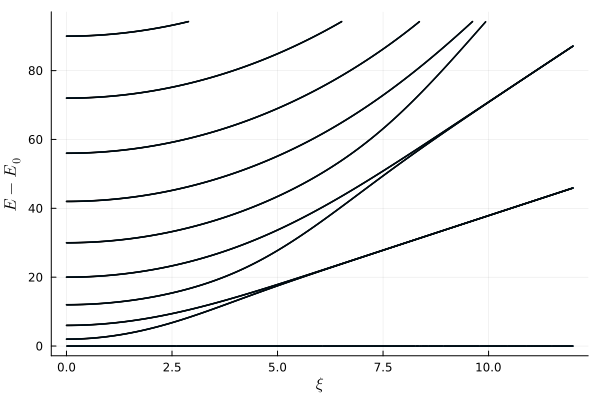

In [76]:
include("../src/src.jl")

using StatsPlots
using LaTeXStrings


df_formatted = filter(row -> row.E_n > 0 &&  row.E_n < 30*pi, df) #match paper limits

@df df_formatted plot(:ξ, :E_n, markersize = .5, xlab=L"\xi",ylab=L"E-E_0",seriestype=:scatter, legend=false)


This agrees with Fig. 1a except for the scale: in the paper, $E'/2 \pi \doteq (E-E_0)/2 \pi$ is plotted against $\xi$, rangeing from $E'/2 \pi \in [0,30]$ which suggests I should limit  $E-E_0 \in [0,2\pi \times 30] \approx [0,190]$ and yet the limits that seems to match best are $E-E_0 \in [0,\pi \times 30] \approx [0,95]$. Perhaps I missed a flying factor of $2$ somewhere?

## 2. Spectrum of the Floquet Hamiltonian
### Overview:
We will now reproduce the above figure but using Floquet theory. We start with a summary of the theory, consider a periodically time dependent Shrodinger equation
$$
H(t) |\psi(t)\rangle = i \partial_t |\psi(t)\rangle \quad \text{ with } \quad H(t+T)=H(t).
$$
Floquet theorem asserts that there exists solutions to the above with the form (¿añadir derivation?)
$$
|\psi_n(t)\rangle  = e^{-it\epsilon_n}|\phi_n(t)\rangle  \quad \text{ with } \quad |\phi_n(t+T)\rangle=|\phi_n(t)\rangle,
$$
where evidently $\epsilon_n$ are defined $\mod(2\pi)$. If we substitute this ansazt into the Schrodinger equation
$$
H(t) \left( e^{-it\epsilon_n}|\phi_n(t)\rangle \right) = i \partial_t  \left( e^{-it\epsilon_n}|\phi_n(t)\rangle \right) \implies H(t) \left( e^{-it\epsilon_n}|\phi_n(t)\rangle \right)  = i \left( -i\epsilon_n e^{-it\epsilon_n}|\phi_n(t)\rangle + e^{-it\epsilon_n} \partial_t |\phi_n(t)\rangle\right)
$$
we yield
$$
 H(t) |\phi_n(t)\rangle = i \left( -i\epsilon_n|\phi_n(t)\rangle + \partial_t |\phi_n(t)\rangle\right) = \left( \epsilon_n +i\partial_t \right) |\phi_n(t)\rangle.
$$
So we conclude
$$
\mathcal{H}(t) |\phi_n(t)\rangle = \epsilon_n |\phi_n(t)\rangle \quad \text{ with } \quad \mathcal{H}(t) \doteq H(t) - i\partial_t.
$$
This is useful because remember that the time independent Schrodinger equation $H|E\rangle = E|E\rangle$ doesnt necessarily hold for time dependent Hamiltonians as its derivation assumes the wavefunction is composed of a product, $f(x)g(t)$, of a function of space and a function of time which is not so reasonable here, rather $f(x,t)$. Anyways, a useful way of finding the quasienergies $\epsilon_n$ is to diagonalise the propagator $U(t_1,t_2)$ as note that by definition
$$
U(t+T,t) |\psi_n(t)\rangle = |\psi_n(t+T)\rangle \quad \text{ but } \quad U(t+T,t) e^{-it\epsilon_n}|\phi_n(t)\rangle  = e^{-i(t+T)\epsilon_n} |\phi_n(t+T)\rangle = e^{-i(t+T)\epsilon_n} |\phi_n(t)\rangle \implies   U(t+T,t) |\phi_n(t)\rangle  = e^{-iT\epsilon_n} |\phi_n(t)\rangle,
$$
concluding
$$
U(t+T,t) |\phi_n(t)\rangle = \eta_n  |\phi_n(t)\rangle \quad \text{ with } \quad \eta_n =   e^{-iT\epsilon_n}.
$$
So we need to either diagonalise the propagator or directly solve the coupled equations of motion for $\mathcal{H}$. On the one hand we can expand perturbatively $U(T)$, the evolution operator, by a Magnus expansion of sorts. We define $U(T) = \exp(-i\Omega(T))$ where
$$
\Omega(t_1,t_2) = \int_{t_1}^{t_2} H(\tau) d\tau + \frac{1}{2} \int_{t_1}^{t_2} d\tau_1 \int_{t_1}^{\tau_1} d \tau_2[H(\tau_1),H(\tau_2)] + \cdots.
$$
We can do something clever, if we perform an unitary transformation of $\mathcal{H}(t)$ with some unitary $W(t)$ we can request
$$
\tilde{\mathcal{H}}(t) = W(t) \mathcal{H}(t) W^\dagger(t) -i W(t)\partial_t W^\dagger(t) = \text{something nice},
$$
as unitary transformations preserve the spectrum of $\mathcal{H}(t)$. If we define $W(t) = \exp(-iK(t))$ then 
$$
\tilde{\mathcal{H}}(t) = \exp(-iK) \mathcal{H}(t) \exp(iK) -i \exp(-iK)\partial_t \exp(iK) = \exp(-iK)  H \exp(iK) - 2i \exp(-iK)\partial_t \exp(iK)
$$
and we can expand in powers of $K(t)$
$$
\tilde{\mathcal{H}}(t) = H(t) + [K(t),H(t)] - \frac{1}{2!} [K(t),[K(t),H(t)]] + \cdots + 2\left[ \partial_t K(t) - \frac{i}{2!}[K(t),\partial_t K(t)] + \cdots \right].
$$

### Case at hand:
Let's compute $\Omega(T)$ perturbatively by doing the product expansion
$$
\Omega(T) = \prod_{n=0}^{M-1} \Omega (t_n,t_{n+1}) \quad \text{ with } \quad t_n \doteq \frac{n}{M}T.
$$
Note that this is more precise than simply doing $\Omega(T) = \Omega(0,T)$ because the error in this product is smaller (multiply the exponentials). 
Anyways, lets do this to second order for the lols, we can generalise this to arbitrary order later on, yuck. So the only non trivial bit is the double integral with the commutator, namely 
$$
 \frac{1}{2} \int_{t_1}^{t_2} d\tau_1 \int_{t_1}^{\tau_1} d \tau_2[H(\tau_1),H(\tau_2)].
$$
Note that for our hamiltonian above, written like $H=H_0 +H_d(t)$, only terms $[H_0,H_d(t)]$ survive. So the above term is 
$$
 \frac{1}{2} \int_{t_1}^{t_2} d\tau_1 \int_{t_1}^{\tau_1} d \tau_2[H(\tau_1),H(\tau_2)] = 
 \frac{1}{2} \int_{t_1}^{t_2} d\tau_1 \int_{t_1}^{\tau_1} d \tau_2 \left( [H_0,H_d(\tau_2)] + [H_d(\tau_1),H_0] \right)=\frac{1}{2}\int_{t_1}^{t_2} d\tau_1 (\tau_1-t_1)[H_d(\tau_1),H_0]  +  \frac{1}{2} \int_{t_1}^{t_2} d\tau_1 \int_{t_1}^{\tau_1} d \tau_2  [H_0,H_d(\tau_2)].
$$
Thus we need to compute
$$
[H_0,H_d(t)] = [\omega_0 a^\dagger a + \sum_{n=3}^\infty g_n (a^\dagger + a)^n , - i\Omega_d \cos(\omega_d t) (a -a^\dagger)].
$$
Note this might be easier in the original "phase space" representation with operators $x=(a+a^\dagger)/\sqrt{2}$ and $p=-i(a-a^\dagger)/\sqrt{2}$ since we know $[x,p]=i$ with this we have
$$
[H_0,H_d(t)] = \left[\frac{\omega_0}{2}(x^2+p^2) + \sum_{n=3}^\infty 2^{n/2} g_n x^n , \Omega_d \cos(\omega_d t)p\right] = \left[\frac{\omega_0}{2}(x^2+p^2) , \Omega_d \cos(\omega_d t)p\right] + \left[\sum_{n=3}^\infty 2^{n/2} g_n x^n , \Omega_d \cos(\omega_d t)p\right],
$$
which simplifies to 
$$
[H_0,H_d(t)] =  \frac{\omega_0}{2}\Omega_d \cos(\omega_d t) \left[x^2 , p\right] + \Omega_d \cos(\omega_d t)\sum_{n=3}^\infty 2^{n/2} g_n \left[ x^n , p\right].
$$
using $[x^n,p]=i n x^{n-1}$ we yield
$$
[H_0,H_d(t)] =  i\omega_0\Omega_d \cos(\omega_d t) x + i\Omega_d \cos(\omega_d t)\sum_{n=3}^\infty 2^{n/2} g_n n x^{n-1},
$$
which back with creation and annihilation ops is
$$
[H_0,H_d(t)] =  i\Omega_d \cos(\omega_d t) \left( \omega_0(a+a^\dagger)/\sqrt{2} +\sum_{n=3}^\infty \frac{2^{n/2}}{2^{(n-1)/2}} g_n n (a+a^\dagger)^{n-1}\right).
$$
So we have
$$
\frac{1}{2} \int_{t_1}^{t_2} d\tau_1 \int_{t_1}^{\tau_1} d \tau_2[H(\tau_1),H(\tau_2)]  =\frac{i\Omega_d}{2} \left( \omega_0(a+a^\dagger)/\sqrt{2} +\sum_{n=3}^\infty \frac{2^{n/2}}{2^{(n-1)/2}} g_n n (a+a^\dagger)^{n-1}\right) \left(\int_{t_1}^{t_2} d\tau_1 (\tau_1-t_1)(- \cos(\omega_d \tau_1)) +  \int_{t_1}^{t_2} d\tau_1 \int_{t_1}^{\tau_1} d \tau_2   \cos(\omega_d \tau_2)\right)
$$
and we just need to do 
$$
\int_{t_1}^{t_2} d\tau_1 (t_1-\tau_1)\cos(\omega_d \tau_1) +  \int_{t_1}^{t_2} d\tau_1 \int_{t_1}^{\tau_1} d \tau_2   \cos(\omega_d \tau_2)
$$

In [ ]:
#takes method for H(t)
function Ω_T_2nd_order(H,T,M)
    N = size(rand(10,10))[1]
    Ω = I(N)
    for n=0:(M-1)
        
        Ω = *Ω
    end
end

In [110]:
rand(10,2)

10×2 Matrix{Float64}:
 0.638869  0.231881
 0.912891  0.503267
 0.586422  0.779201
 0.106054  0.626612
 0.172015  0.29636
 0.44859   0.45781
 0.8916    0.435741
 0.955644  0.129365
 0.270362  0.925196
 0.349254  0.464371

### Spectrum of $H_0$

In [94]:
# H_0 where g_n is a vector 
function H_0(N,ω_0, g_n::Vector)
    A = a(N) # annahilation op. up to dim N
    exp_order = length(g_n)
    expansion = [(A' + A)^n for n=3:(2+exp_order)]
    return  ω_0*A'*A - g_n'*expansion
end

H_0 (generic function with 1 method)

In [103]:
lamb, vec= eigen(H_0(4,1,[1,-1/2]))

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
4-element Vector{Float64}:
  0.1644390298690446
  2.0471245946305343
  4.285629362094596
 29.50280701340578
vectors:
4×4 Matrix{Float64}:
  0.946091   0.212726  0.140802  -0.199584
  0.24324   -0.799985  0.259337   0.483324
 -0.186392  -0.247563  0.669433  -0.675152
 -0.1049     0.503472  0.681747   0.520321

In [107]:
diagm(lamb) + vec'*(a(4)-a(4)')*vec

4×4 Matrix{Float64}:
  0.164439  -1.31216   0.411284   0.110321
  1.31216    2.04712  -1.37486    1.24185
 -0.411284   1.37486   4.28563    0.815163
 -0.110321  -1.24185  -0.815163  29.5028